In [1]:
import io

In [ ]:
io.StringIO()

In [6]:
from pathlib import Path
import os
import cv2
import tarfile
import tensorflow as tf
import torch, sys, cv2, os
sys.path.append(str(Path("./")))
sys.path.insert(1, 'pytorch_deep_image_matting/core')
import numpy as np
from imageio import imread,imsave
import time

from utils import loaders,nnmodels
from copy_paste import integration as intg
from copy_paste import net

# Load Model

In [7]:
G_body=torch.load("./model_body/netGbody_struct.pth").cuda(0)
G_body.load_state_dict(torch.load("./model_body/netGbody_run220.pt"))
G_face=torch.load("./model_face/netGface_struct.pth").cuda(0)
G_face.load_state_dict(torch.load("./model_face.old/netGface_run410.pt"))
Model = net.DeepLabModel("./copy_paste/model/model_xception65_coco_voc_trainval.tar.gz")
Mat_model = net.VGG16(1).cuda(0)
Mat_model.load_state_dict(torch.load("./copy_paste/model/VGG16_weight.pt"))    

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

# Parameters and little function

In [8]:
label_path="../test/test_label/test_img_keypoints.json"
HALF_HEAD=loaders.HEAD_SIZE//2
lbl_sample,head_mtx,head_center = loaders.read_label(label_path,ifhead=True,ifbody=True)
def to_4d(inp):
    return np.expand_dims(inp,0)
def patch_head(body_img,head_img,head_center):
    body_img[:,:,head_center[1]-HALF_HEAD:head_center[1]+HALF_HEAD,head_center[0]-HALF_HEAD:head_center[0]+HALF_HEAD]=head_img
    return torch.squeeze(norm_0to1(body_img),0)
def norm_0to1(inp):
    return (inp-inp.min())/(inp.max()-inp.min())

# Gen body from stick

In [9]:
body_img=G_body(torch.tensor(to_4d(lbl_sample), device=torch.device('cuda:0')))
print(body_img.shape,body_img.min(),body_img.max())

torch.Size([1, 3, 512, 512]) tensor(-0.9484, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8695, device='cuda:0', grad_fn=<MaxBackward1>)


# Enhance Face from face point and raw fake head

In [10]:
fake_head=body_img[:,:,head_center[1]-HALF_HEAD:head_center[1]+HALF_HEAD,\
                               head_center[0]-HALF_HEAD:head_center[0]+HALF_HEAD]
head_lbl=torch.tensor(to_4d(head_mtx),dtype=torch.float32, device=torch.device('cuda:0'))
print(fake_head.shape,fake_head.min(),fake_head.max())
print(head_lbl.shape,head_lbl.min(),head_lbl.max())
head_input=torch.cat((fake_head, head_lbl), dim=1)
head_enhance=G_face(head_input)+fake_head
print(head_enhance.shape,head_enhance.min(),head_enhance.max())
body_img[:,:,head_center[1]-HALF_HEAD:head_center[1]+HALF_HEAD,head_center[0]-HALF_HEAD:head_center[0]+HALF_HEAD]=head_enhance
print(body_img.shape,body_img.min(),body_img.max())

torch.Size([1, 3, 64, 64]) tensor(-0.9041, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8695, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 15, 64, 64]) tensor(0., device='cuda:0') tensor(1., device='cuda:0')
torch.Size([1, 3, 64, 64]) tensor(-1.2773, device='cuda:0', grad_fn=<MinBackward1>) tensor(1.1606, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 3, 512, 512]) tensor(-1.2773, device='cuda:0', grad_fn=<MinBackward1>) tensor(1.1606, device='cuda:0', grad_fn=<MaxBackward1>)


In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.imshow(norm_0to1(body_img).squeeze().detach().cpu().numpy().transpose(1,2,0))

# Human Mask Generation

In [12]:
animeimg=norm_0to1(body_img).detach().cpu().numpy().transpose(0,2,3,1)

In [13]:
animeimg[0].shape

(512, 512, 3)

In [14]:
imsave("../test/temp2.png",animeimg[0])

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


0.0 1.0 (512, 512)


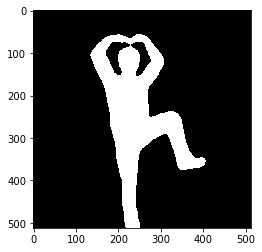

In [15]:
# Mask for anime Charactor
torch.cuda.empty_cache()
inf_mask = np.sign(Model.run(animeimg*255),dtype=np.float32)
print(inf_mask.min(),inf_mask.max(),inf_mask.shape)
import matplotlib.pyplot as plt
plt.imshow(inf_mask,"gray")

In [16]:
#Human
photo_input=np.expand_dims(imread("../test/test_img/test_img.png"),0)
print(photo_input.min(),photo_input.max(),photo_input.shape)

0 255 (1, 512, 512, 3)


0.0 1.0 (512, 512)


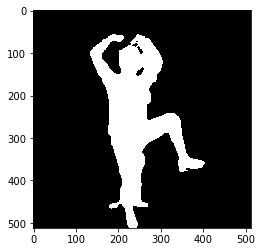

In [17]:
# Mask for Human
torch.cuda.empty_cache()
photo_mask = np.sign(Model.run(photo_input),dtype=np.float32)
print(photo_mask.min(),photo_mask.max(),photo_mask.shape)
import matplotlib.pyplot as plt
plt.imshow(photo_mask,"gray")

# Trim map generation

In [18]:
size=15; erosion=2

In [19]:
in_mask = inf_mask

* ### Erotion

In [20]:
pixels = 2*size + 1;                                     ## Double and plus 1 to have an odd-sized kernel
kernel = np.ones((pixels,pixels),np.uint8)               ## How many pixel of extension do I get

if erosion is not False:
    erosion = int(erosion)
    erosion_kernel = np.ones((3,3), np.uint8)                     ## Design an odd-sized erosion kernel
    msk = cv2.erode(in_mask, erosion_kernel, iterations=erosion)  ## How many erosion do you expect
    #image = np.where(image > 0, 255, image)                       ## Any gray-clored pixel becomes white (smoothing)
    # Error-handler to prevent entire foreground annihilation
    if cv2.countNonZero(msk) == 0:
        print("ERROR: foreground has been entirely eroded");
        sys.exit();
dilation  = cv2.dilate(msk, kernel, iterations = 1)

dilation  = np.where(dilation == 1., 0.5, dilation) 	## WHITE to GRAY
remake    = np.where(dilation != 0.5, 0., dilation)		## Smoothing
remake    = np.where(msk > 0.5, 200/255, dilation)		## mark the tumor inside GRAY
remake    = np.where(remake < 0.5, 0., remake)		## Embelishment
remake    = np.where(remake > 200/255, 0., remake)		## Embelishment
remake    = np.where(remake == 200/255, 1., remake)		## GRAY to WHITE

#############################################
# Ensures only three pixel values available #
# TODO: Optimization with Cython            #
#############################################    
remake[np.logical_and(remake != 0. ,remake != 1.)]=0.5

* ### Dilation

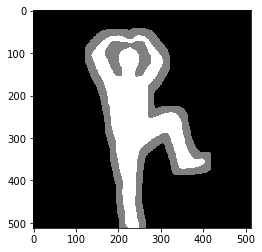

In [21]:
import matplotlib.pyplot as plt
plt.imshow(remake,"gray")

(array([194058.,      0.,      0.,      0.,      0.,  30917.,      0.,
             0.,      0.,  37169.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <a list of 10 Patch objects>)

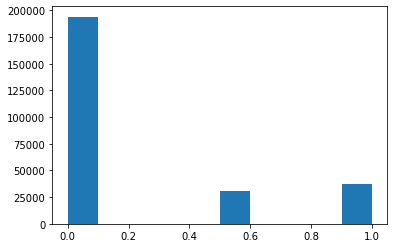

In [22]:
plt.hist(remake.flatten())

In [23]:
trimap=remake

# Matting

In [24]:
animeimg.shape

(1, 512, 512, 3)

In [25]:
animeimg[0].shape

(512, 512, 3)

In [26]:
max_size=1600
h, w, c = animeimg[0].shape

In [27]:
import torchvision.transforms as ts
normalize = ts.Compose([
            ts.Normalize(mean = [0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225])
        ])

In [28]:
normalize = ts.Compose([
            ts.Normalize(mean = [0.5, 0.5, 0.5],std = [0.5, 0.5, 0.5])
        ])

In [29]:
print(body_img[0].shape,body_img[0].max(),body_img[0].min(),'\n')
print(animeimg[0].shape,animeimg[0].max(),animeimg[0].min())

torch.Size([3, 512, 512]) tensor(1.1606, device='cuda:0', grad_fn=<MaxBackward1>) tensor(-1.2773, device='cuda:0', grad_fn=<MinBackward1>) 

(512, 512, 3) 1.0 0.0


In [30]:
tensor_img=normalize(body_img[0]).unsqueeze(0)

In [31]:
cuda_device=torch.device("cuda")
tensor_trimap=torch.tensor(trimap,device=cuda_device,dtype=torch.float32).unsqueeze(0).unsqueeze(0)

### Tensor grad好像沒用到?!?!?!?!??!

In [32]:
print(tensor_trimap.shape)

torch.Size([1, 1, 512, 512])


In [33]:
input_t = torch.cat((body_img, tensor_trimap), 1)

In [34]:
pred_mattes, _ = Mat_model(input_t)

In [35]:
print(pred_mattes.min(),pred_mattes.max(),pred_mattes.shape)

tensor(5.0630e-19, device='cuda:0', grad_fn=<MinBackward1>) tensor(1., device='cuda:0', grad_fn=<MaxBackward1>) torch.Size([1, 1, 512, 512])


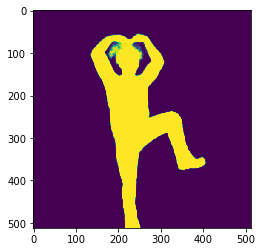

In [36]:
plt.imshow(pred_mattes.squeeze().detach().cpu().numpy())

In [37]:
origin_pred_mattes = pred_mattes.data.detach().cpu().numpy()[0, 0, :, :]

In [38]:
alpha=origin_pred_mattes



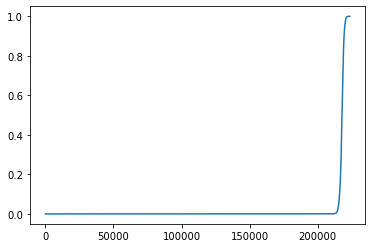

In [39]:
plt.plot(np.unique(alpha))

In [40]:
alpha=pred_mattes[0].data.detach().cpu().numpy().transpose(1,2,0)
alpha=alpha>0.99

In [41]:
AAA=alpha*animeimg[0]

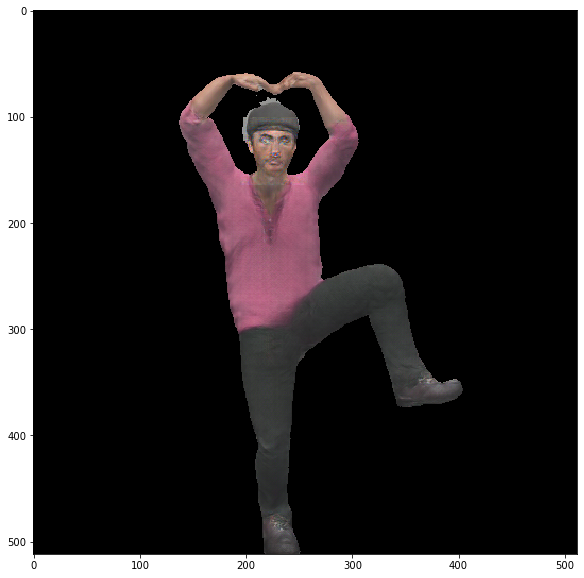

In [42]:
plt.figure(figsize=(10,10))
plt.imshow(AAA)

In [43]:
tatal_mask=np.expand_dims(1-np.logical_or(photo_mask,inf_mask),2)

0 1 (512, 512, 1)


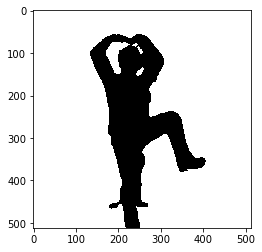

In [44]:
print(tatal_mask.min(),tatal_mask.max(),tatal_mask.shape)
import matplotlib.pyplot as plt
plt.imshow(tatal_mask[...,0],"gray")

In [45]:
alpha.shape

(512, 512, 1)

In [46]:
edge=np.logical_xor(tatal_mask,1-alpha)

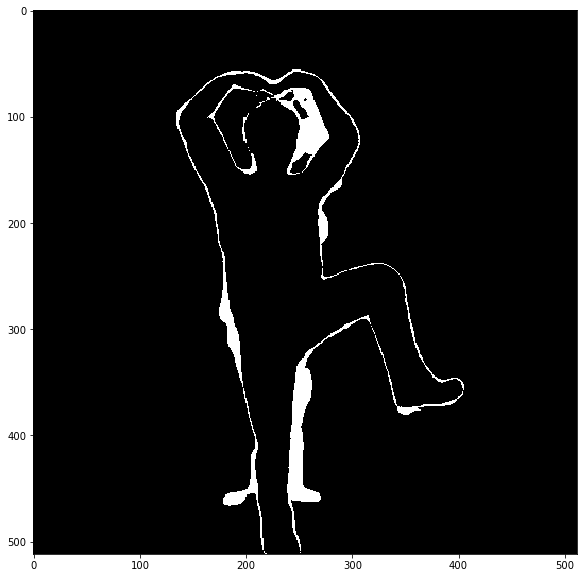

In [207]:
plt.figure(figsize=(10,10))
plt.imshow(edge[...,0],"gray")

In [208]:
KERNEL=np.array([[0, 0, 1, 1 ,1, 0, 0],
                 [0, 0, 1, 1, 1, 0, 0],
                 [1, 1, 1, 1, 1, 1, 1],
                 [1, 1, 1, 1, 1, 1, 1],
                 [1, 1, 1, 1, 1, 1, 1],
                 [0, 0, 1, 1, 1, 0, 0],
                 [0, 0, 1, 1 ,1, 0, 0]], dtype=np.uint8)
def blur_fun(im):
    return cv2.GaussianBlur(im,(31,31),0)
def edge_blur(img,mask):
    # convert to 0~1
    mask=(mask/mask.max()).round()
    # create eroded mask+edge mask
    fatmask=cv2.erode(mask,KERNEL,iterations=1)
    gradient = cv2.morphologyEx(fatmask, cv2.MORPH_GRADIENT, KERNEL,iterations=2) 
    # Edge Image bluring
    b_img=blur_fun(img*gradient)
    # combine 2 images
    return img*(fatmask==1)+b_img*(fatmask!=1)

In [209]:
b_img=edge_blur(photo_input[0],np.repeat(tatal_mask,3,axis=2))/255

In [210]:
b_img.min()

0.0

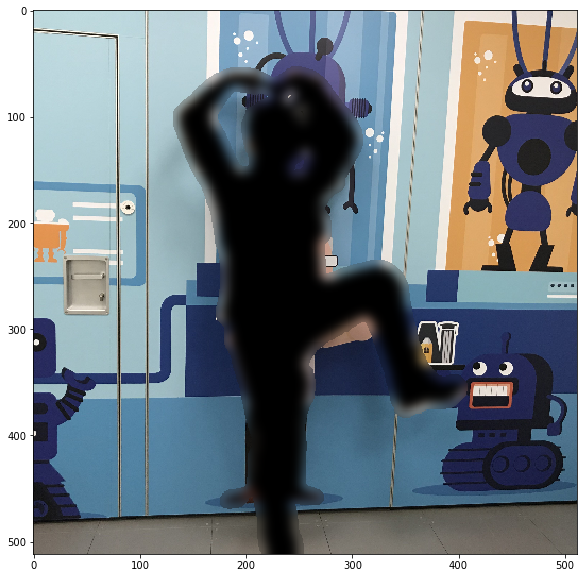

In [211]:
plt.figure(figsize=(10,10))
plt.imshow(b_img,"gray")

In [157]:
(np.repeat(alpha,3,axis=2)==1).shape

(512, 512, 3)

In [202]:
alpha

array([-1.,  1.], dtype=float32)

In [212]:
#good_bg = intg.edge_blur(photo_input[0],1-tatal_mask)
good_img=b_img*(1-alpha)+animeimg[0]*alpha

In [213]:
b_img.min(),animeimg[0].min()

(0.0, 0.0)

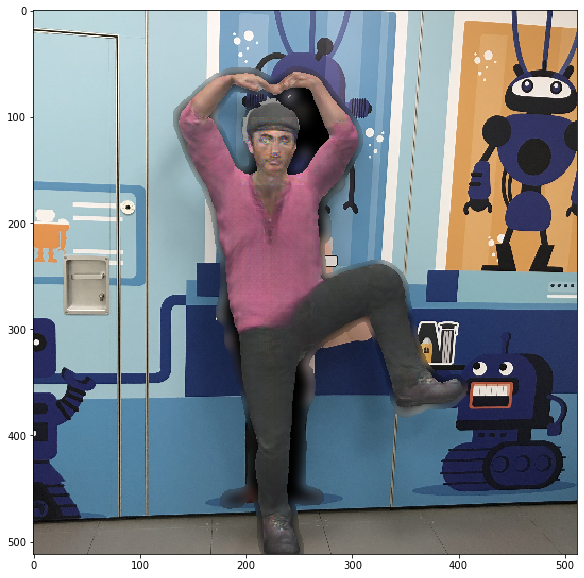

In [214]:
plt.figure(figsize=(10,10))
plt.imshow(good_img,"gray")

In [196]:
tri_inf = gen_trimap(inf_mask, size = 0, erosion = 1)

generate trimap(size: 0, erosion: 1)


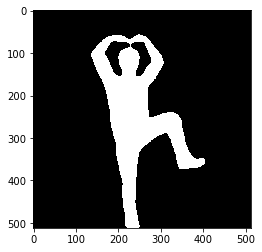

In [197]:
plt.imshow(tri_inf,"gray")

In [ ]:
blur = intg.edge_blur(compos,b)

NameError: name 'compos' is not defined

In [181]:
def gen_trimap(in_mask, size, erosion=False):
    pixels = 2*size + 1;                                     ## Double and plus 1 to have an odd-sized kernel
    kernel = np.ones((pixels,pixels),np.uint8)               ## How many pixel of extension do I get

    if erosion is not False:
        erosion = int(erosion)
        erosion_kernel = np.ones((3,3), np.uint8)                     ## Design an odd-sized erosion kernel
        msk = cv2.erode(in_mask, erosion_kernel, iterations=erosion)  ## How many erosion do you expect
        #image = np.where(image > 0, 255, image)                       ## Any gray-clored pixel becomes white (smoothing)
        # Error-handler to prevent entire foreground annihilation
        if cv2.countNonZero(msk) == 0:
            print("ERROR: foreground has been entirely eroded");
            sys.exit();
    dilation  = cv2.dilate(msk, kernel, iterations = 1)

    dilation  = np.where(dilation == 1., 0.5, dilation) 	## WHITE to GRAY
    remake    = np.where(dilation != 0.5, 0., dilation)		## Smoothing
    remake    = np.where(msk > 0.5, 200/255, dilation)		## mark the tumor inside GRAY
    remake    = np.where(remake < 0.5, 0., remake)		## Embelishment
    remake    = np.where(remake > 200/255, 0., remake)		## Embelishment
    remake    = np.where(remake == 200/255, 1., remake)		## GRAY to WHITE

    #############################################
    # Ensures only three pixel values available #
    # TODO: Optimization with Cython            #
    #############################################    
    remake[np.logical_and(remake != 0. ,remake != 1.)]=0.5
    print("generate trimap(size: " + str(size) + ", erosion: " + str(erosion) + ")")
    return remake

In [ ]:
img = intg.convert(Model= Model, Mat_model=Mat_model,photo_input = input_dir+"/"+im_name+".png",
            inference = "./test/temp.png",
            output_dir='./results')

In [4]:
import imageio
import matplotlib.pyplot as plt 
%matplotlib inline

In [5]:
img = imageio.imread('./cat_head_body.png')

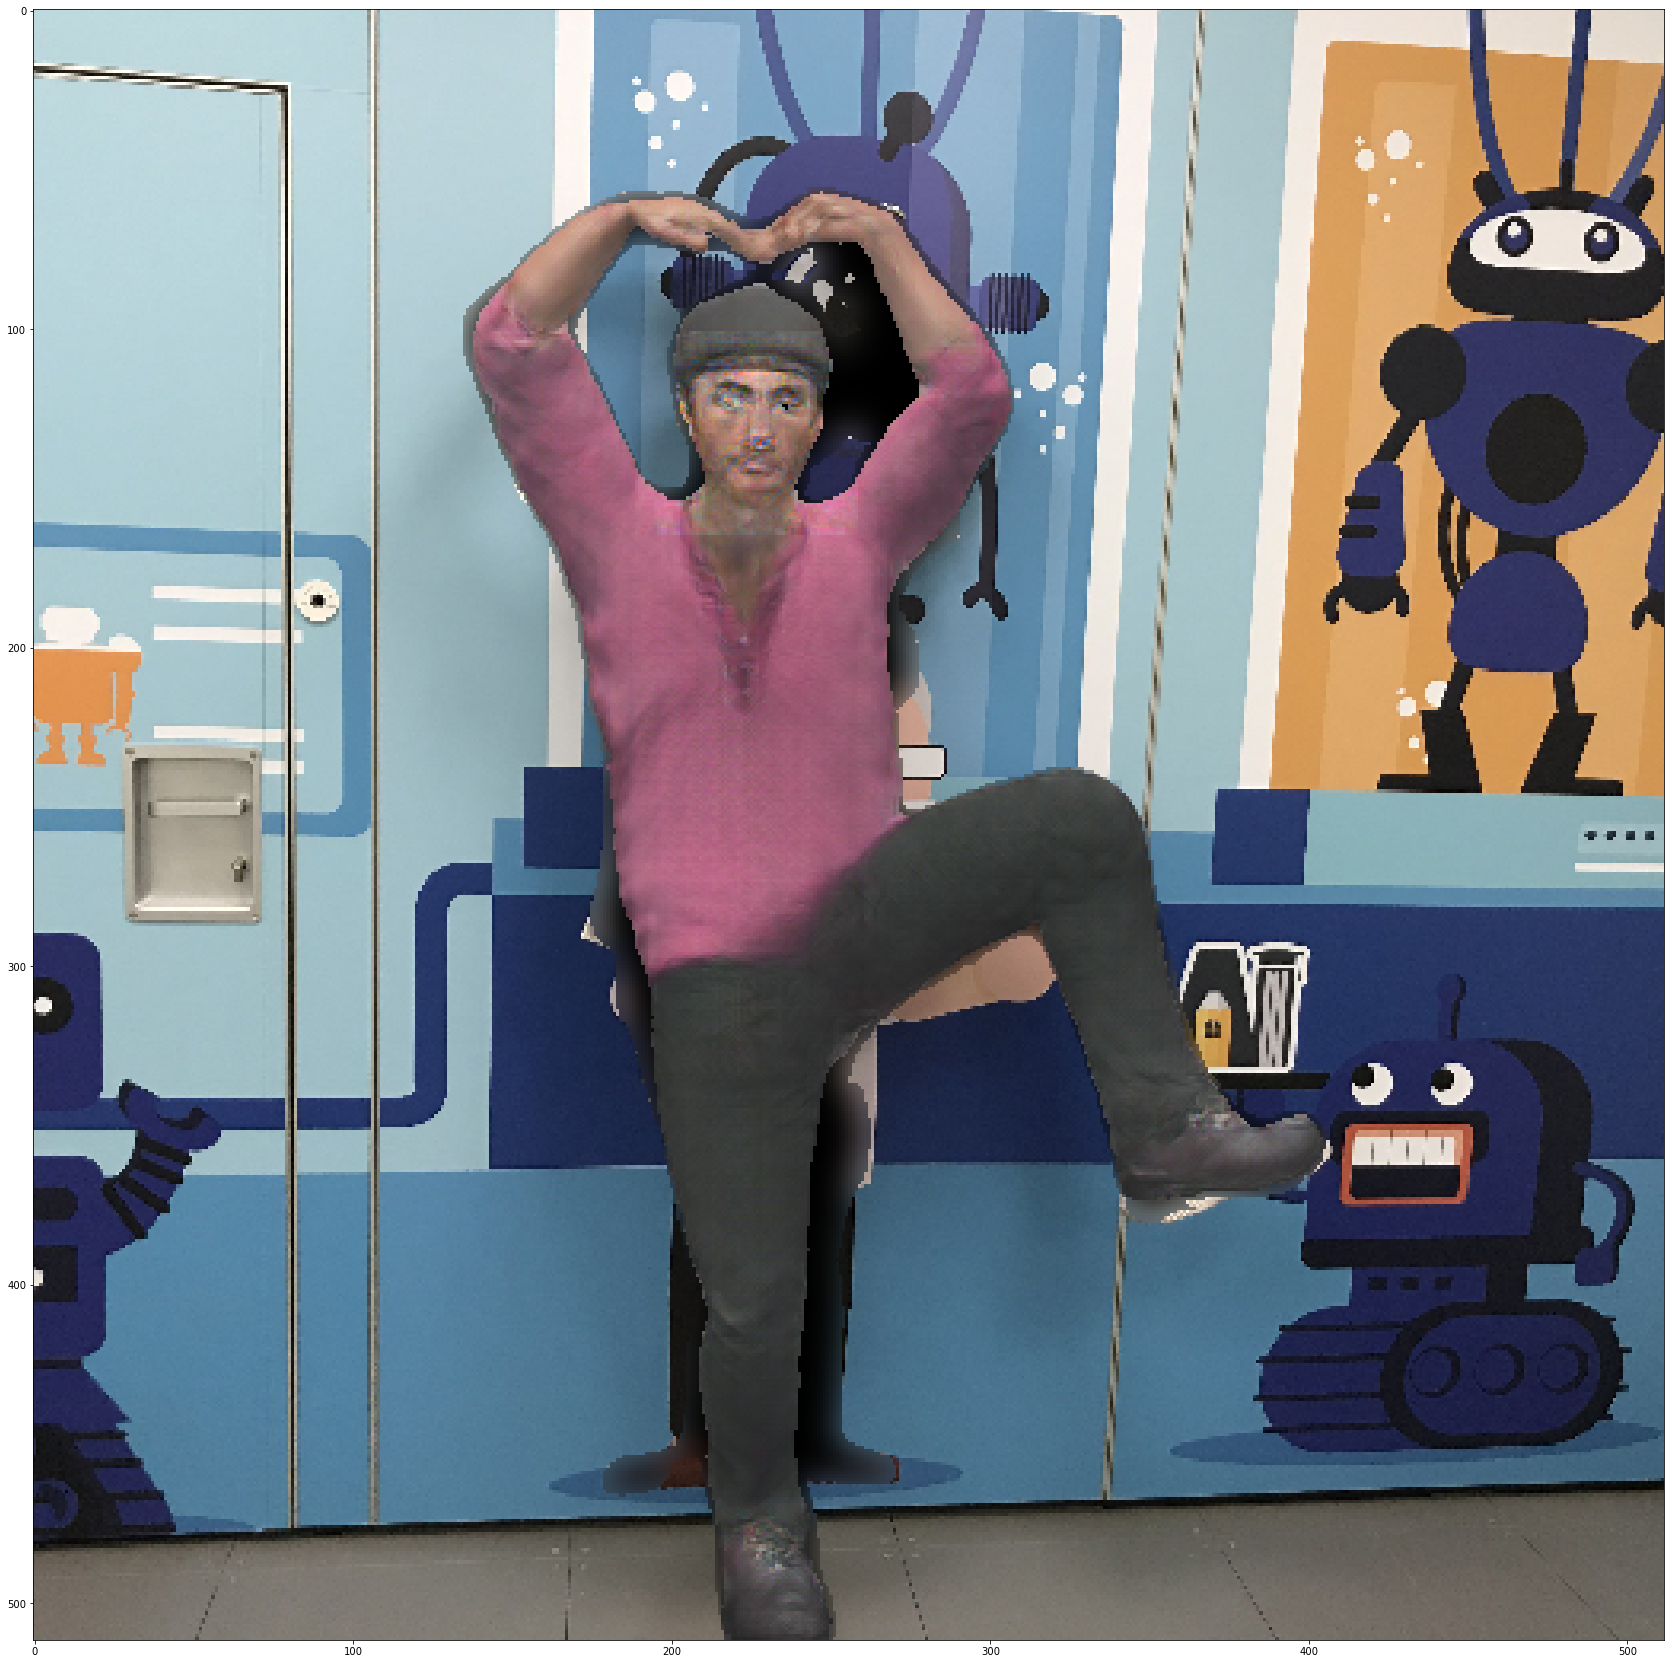

In [7]:
plt.figure(figsize=(30,30))
plt.imshow(img)